In [2]:
import numpy as np 
import awkward as ak
import sys
sys.path.append("..")
from binary_decoders import lecroy
from oscilliscope_fitting import mcp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import importlib
from scipy import interpolate
import uproot

5000
4994


/home/users/hswanson13/ETL_TestingDAQ/notebooks/../oscilliscope_fitting/mcp.py:49: RuntimeWarning: divide by zero encountered in divide
  return -B/(2*A), C - B**2/(4*A) #-> x_interpolated_peak, y_interpolated_peak
/home/users/hswanson13/ETL_TestingDAQ/notebooks/../oscilliscope_fitting/mcp.py:49: RuntimeWarning: invalid value encountered in divide
  return -B/(2*A), C - B**2/(4*A) #-> x_interpolated_peak, y_interpolated_peak


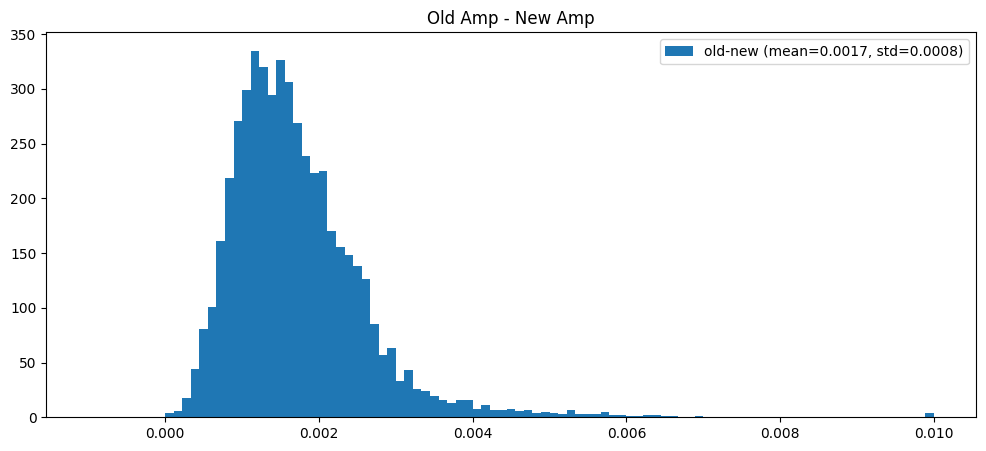

In [11]:
importlib.reload(mcp)
importlib.reload(lecroy)
old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_amp = -old.amp[:,1]/1000

conv_old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
nano_times = conv_old.time[:,0]*1e9

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(nano_times, mcp_data.y)

# Plot histograms
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
d = old_amp - peak_ys

print(len(d))
print(len(d[np.isfinite(d)]))
mean_diff = np.mean(d[np.isfinite(d)])
std_diff = np.std(d[np.isfinite(d)])
bins = np.linspace(-0.001, 0.01, 100)
plt.hist(np.clip(old_amp-peak_ys, bins[0], bins[-1]), 
         bins=bins,  
         label=f"old-new (mean={mean_diff:.4f}, std={std_diff:.4f})")
axs.set_title('Old Amp - New Amp')
plt.legend()


-1.0332693
-0.0012826493561332959
5000
4998


/home/users/hswanson13/ETL_TestingDAQ/notebooks/../oscilliscope_fitting/mcp.py:49: RuntimeWarning: divide by zero encountered in divide
  return -B/(2*A), C - B**2/(4*A) #-> x_interpolated_peak, y_interpolated_peak
/home/users/hswanson13/ETL_TestingDAQ/notebooks/../oscilliscope_fitting/mcp.py:49: RuntimeWarning: invalid value encountered in divide
  return -B/(2*A), C - B**2/(4*A) #-> x_interpolated_peak, y_interpolated_peak


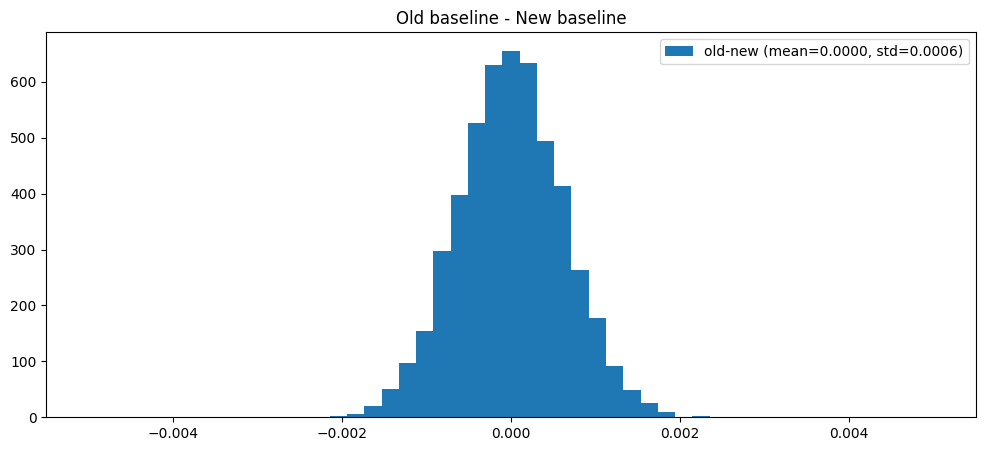

In [13]:
importlib.reload(mcp)
old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_amp = -old.amp[:,1]/1000
old_baseline = old.baseline[:,1]/1000
old_baseline_RMS = old.baseline_RMS[:,1]

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")

peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(mcp_data.x*1e9, mcp_data.y)
baselines = mcp.MCPSignalScaler._calc_baselines(mcp_data.x*1e9, mcp_data.y, peak_xs, peak_ys)

# Plot histograms
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

d = old_baseline - baselines
print(old.baseline[:,1][0])
print(baselines[0])
print(len(d))
print(len(d[np.isfinite(d)]))
mean_diff = np.mean(d[np.isfinite(d)])
std_diff = np.std(d[np.isfinite(d)])

bins = np.linspace(-0.005, 0.005, 50)
plt.hist(np.clip(old_baseline-baselines, bins[0], bins[-1]), 
         bins=bins,  
         label=f"old-new (mean={mean_diff:.4f}, std={std_diff:.4f})")

axs.set_title('Old baseline - New baseline')
plt.legend()


5000


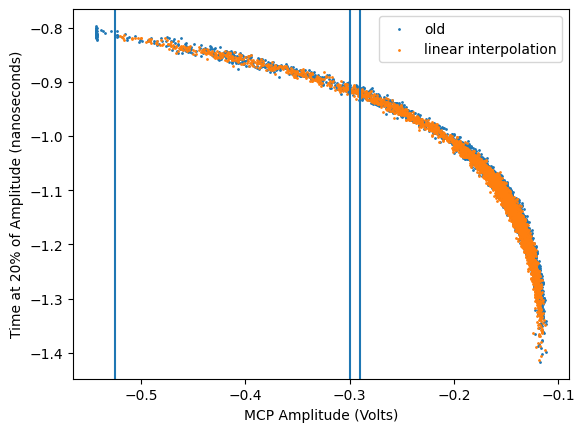

In [30]:
importlib.reload(mcp)
importlib.reload(lecroy)
# def linear_interpolation(x, y, peak_xs, plot_idx=None):
#     rising_volts_mask = x < peak_xs[:, np.newaxis]
#     rising_ns = np.where(rising_volts_mask, x, np.NaN)
#     rising_v = np.where(rising_volts_mask, y, np.NaN)

#     time_of_threshold = []
#     for i in range(len(rising_ns)):
#         try:
#             lin_interp = interpolate.interp1d(rising_v[i], rising_ns[i])
#             time_of_threshold.append(lin_interp(0.4))
#             if plot_idx == i:
#                 mask = rising_ns[i] > -5
#                 plt.plot(rising_ns[i][mask], rising_v[i][mask], marker='.')
#                 plt.axvline(lin_interp(0.2), color='red')
#                 plt.axvspan(lin_interp(0.2)-0.05, lin_interp(0.2)+0.05, facecolor='red', alpha=0.5)
#                 plt.axhline(0.2, color='black', linestyle='--')
#                 break
#         except ValueError:
#             time_of_threshold.append(0)
#             print(f"Broken Interpolation! on {i}")
#             mask = rising_ns[i] > -5
#             plt.plot(rising_ns[i][mask], rising_v[i][mask], marker='.')
#             break
#     return np.array(time_of_threshold)

def linear_interpolation(x, y, peak_xs, threshold=0.4):
    rising_volts_mask = x < peak_xs[:, np.newaxis]
    rising_ns = np.where(rising_volts_mask, x, np.NaN)
    rising_v = np.where(rising_volts_mask, y, np.NaN)
    
    upper_idx = np.argmax(rising_v > 0.4, axis=1)
    lower_idx = upper_idx - 1

    event_idx = range(len(upper_idx))
    # NOTE: x is voltages so we can use the formula below and plug in the threshold, too lazy to invert it haha
    x1, x2 = rising_v[event_idx, lower_idx], rising_v[event_idx, upper_idx]
    y1, y2 = rising_ns[event_idx, lower_idx], rising_ns[event_idx, upper_idx]
    return ((y2 - y1)*threshold + x2*y1 - x1*y2) / (x2 - x1)

ref_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C1--Trace5100.trc")
_, chorz = ref_data.segment_times

old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_lp2 = old.LP2_40[:,1]
old_amp = -old.amp[:,1]/1000
# old_baseline = old.baseline[:,1]/1000
# old_baseline_RMS = old.baseline_RMS[:,1]
# old_toff = old.timeoffsets[:,1]*1e9
# old_toff = old_toff.to_numpy()

conv_old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
old_nano_times = conv_old.time[:,0]*1e9
old_nano_times = old_nano_times.to_numpy()
old_volts = conv_old.channel[:,1].to_numpy()
old_toffset = conv_old.timeoffsets[:,1]*1e9
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
_, horz_off = mcp_data.segment_times

scaled_s, scaled_v = mcp.MCPSignalScaler.normalize(mcp_data.x*1e9, mcp_data.y)
peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(scaled_s, mcp_data.y)

plt.scatter(old_amp, old_lp2*10**9, s=1, label="old")

# # 2. Linear interpolation
toff = (chorz - horz_off)*1e9
time_L20 = linear_interpolation(scaled_s, scaled_v, peak_xs) #+toff

print(len(time_L20))
# good_fits = (time_L20 != 0) & (time_L20 > -3)
plt.scatter(peak_ys, time_L20, s=1, label="linear interpolation")

plt.xlabel("MCP Amplitude (Volts)")
plt.ylabel("Time at 20% of Amplitude (nanoseconds)")
plt.legend()

plt.axvline(-0.3)
plt.axvline(-0.29)
plt.axvline(mcp_data.minVerticalValue)

-----------
41
-0.013999999999996023
-0.013999999999996023
32
25


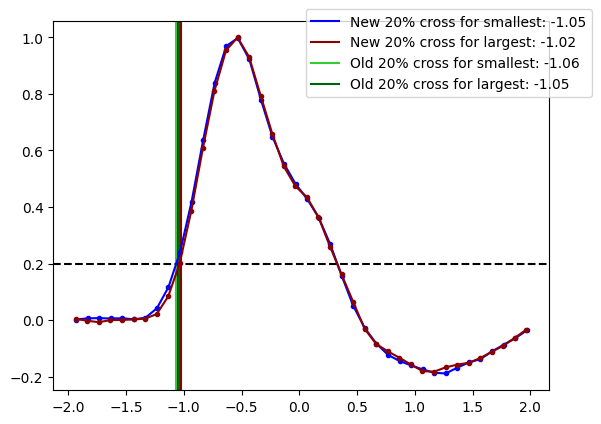

In [9]:
# Investigation of large signals
importlib.reload(mcp)
from scipy import interpolate

def linear_interpolation(x, y, peak_xs):
    rising_volts_mask = x < peak_xs[:, np.newaxis]
    rising_ns = np.where(rising_volts_mask, x, np.NaN)
    rising_v = np.where(rising_volts_mask, y, np.NaN)

    time_of_threshold = []
    for rv, rs in zip(rising_v, rising_ns):
        try:
            lin_interp = interpolate.interp1d(rv, rs)
            time_of_threshold.append(lin_interp(0.2))
        except ValueError:
            time_of_threshold.append(0)
    return np.array(time_of_threshold)

old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_amp = -old.amp[:,1]/1000
old_baseline = old.baseline[:,1]/1000
old_toff = old.timeoffsets[:,1]*1e9

conv_old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
#nano_times = conv_old.time[:,0]*1e9

# big_peak_mask = (old_amp > -0.3) & (old_amp <-0.29)

## Large Amplitudes
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
nano, volts = mcp.MCPSignalScaler.normalize(mcp_data.x*1e9, mcp_data.y)
peak_xs, peak_ys = mcp.MCPSignalScaler._calc_mcp_peaks(nano, mcp_data.y)
baselines = mcp.MCPSignalScaler._calc_baselines(nano, mcp_data.y, peak_xs, peak_ys)

big_peak_mask = (peak_ys > -0.3) & (peak_ys <-0.29)
big_ns = nano[big_peak_mask]
big_v = volts[big_peak_mask]
old_big_amps = old_amp[big_peak_mask]
big_baselines = baselines[big_peak_mask]
big_peak_ys = peak_ys[big_peak_mask]
big_ys = mcp_data.y[big_peak_mask]
big_toff = old_toff[big_peak_mask]
big_new_toff = toff[big_peak_mask]

time_L20 = linear_interpolation(big_ns, big_v, peak_xs[big_peak_mask])

min_idx = np.argmin(time_L20)
max_idx = np.argmax(time_L20)

plt.axvline(time_L20[min_idx], label=f'New 20% cross for smallest: {time_L20[min_idx]:.3}', color='blue')
plt.axvline(time_L20[max_idx], label=f'New 20% cross for largest: {time_L20[max_idx]:.3}', color='darkred')

plt.axvline(old_lp2[big_peak_mask][min_idx]*1e9, label=f'Old 20% cross for smallest: {old_lp2[big_peak_mask][min_idx]*1e9:.3}', color='limegreen')
plt.axvline(old_lp2[big_peak_mask][max_idx]*1e9, label=f'Old 20% cross for largest: {old_lp2[big_peak_mask][max_idx]*1e9:.3}', color='darkgreen')

plt.axhline(0.2, color="black", linestyle='--')
i_plot = 0 #argmin
min_window = (big_ns[min_idx] < 2) & (big_ns[min_idx] > -2)
max_window = (big_ns[max_idx] < 2) & (big_ns[max_idx] > -2)

plt.plot(big_ns[min_idx][min_window]+big_new_toff[min_idx], 
         big_v[min_idx][min_window], marker='.', color='blue')
plt.plot(big_ns[max_idx][max_window]+big_new_toff[max_idx], 
         big_v[max_idx][max_window], marker='.', color='darkred')

print('-----------')
print(len(time_L20))
print(big_new_toff[max_idx])
print(big_new_toff[min_idx])
print(max_idx)
print(min_idx)
plt.legend(bbox_to_anchor=(1.1, 1.05))

# plt.clf()

# plt.plot(big_ns[np.argmin(time_L20)][view_window], 
#          big_ys[np.argmin(time_L20)][view_window], marker='.', color='blue')
# plt.plot(big_ns[np.argmax(time_L20)][view_window], 
#          big_ys[np.argmax(time_L20)][view_window], marker='.', color='darkred')

# x_center = np.take(big_ns[np.argmax(time_L20)], big_ns[np.argmax(time_L20)].size // 2)
# y_center = np.take(big_ys[np.argmax(time_L20)], big_ys[np.argmax(time_L20)].size // 2)
# plt.scatter(x_center, y_center, s=80, facecolors='none', edgecolors='r')


new offset -0.013999999999996023
old offset 0.0139999995
mean difference -0.013999962504852687


Ellipsis

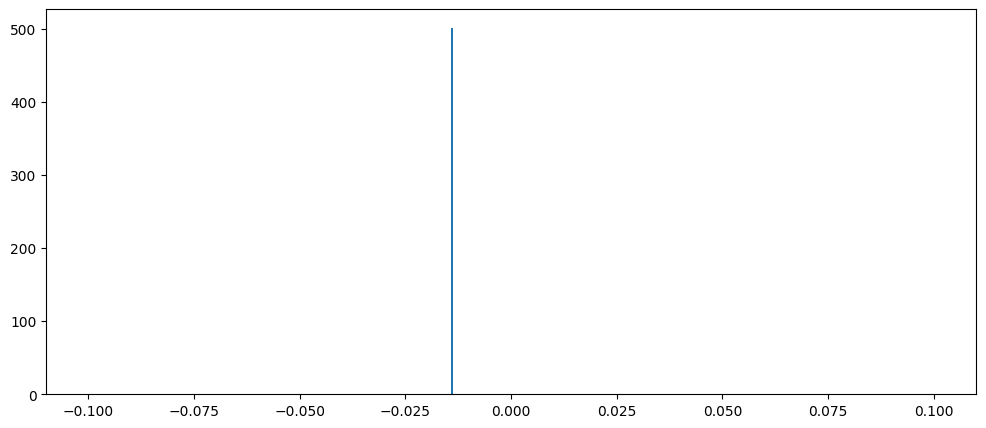

In [39]:
importlib.reload(lecroy)
importlib.reload(mcp)


ref_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C1--Trace5100.trc")
_, chorz = ref_data.segment_times

clock_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C3--Trace5100.trc")

conv_old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
old_nano_times = conv_old.time[:,0]*1e9
old_nano_times = old_nano_times.to_numpy()
big_old_nano_times = old_nano_times[big_peak_mask]
old_toffset = conv_old.timeoffsets[:,1]*1e9
big_old_toffset = old_toffset[big_peak_mask]

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
_, horz_off = mcp_data.segment_times
big_horz_off = horz_off[big_peak_mask]
big_chorz_off = chorz[big_peak_mask]

i_plot = 25
new_offset = (big_chorz_off-big_horz_off)*1e9
print("new offset",new_offset[i_plot])
print("old offset",big_old_toffset[i_plot])
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

d = big_old_nano_times[i_plot] - mcp_data.x[big_peak_mask][i_plot]*1e9
mean_diff = np.mean(d[np.isfinite(d)])
std_diff = np.std(d[np.isfinite(d)])
print("mean difference",mean_diff)
bins = np.linspace(-0.1, 0.1, 500)
plt.hist(np.clip(d, bins[0], bins[-1]), 
         bins=bins,  
         label=f"old-new (mean={mean_diff:.4f}, std={std_diff:.4f})")
...


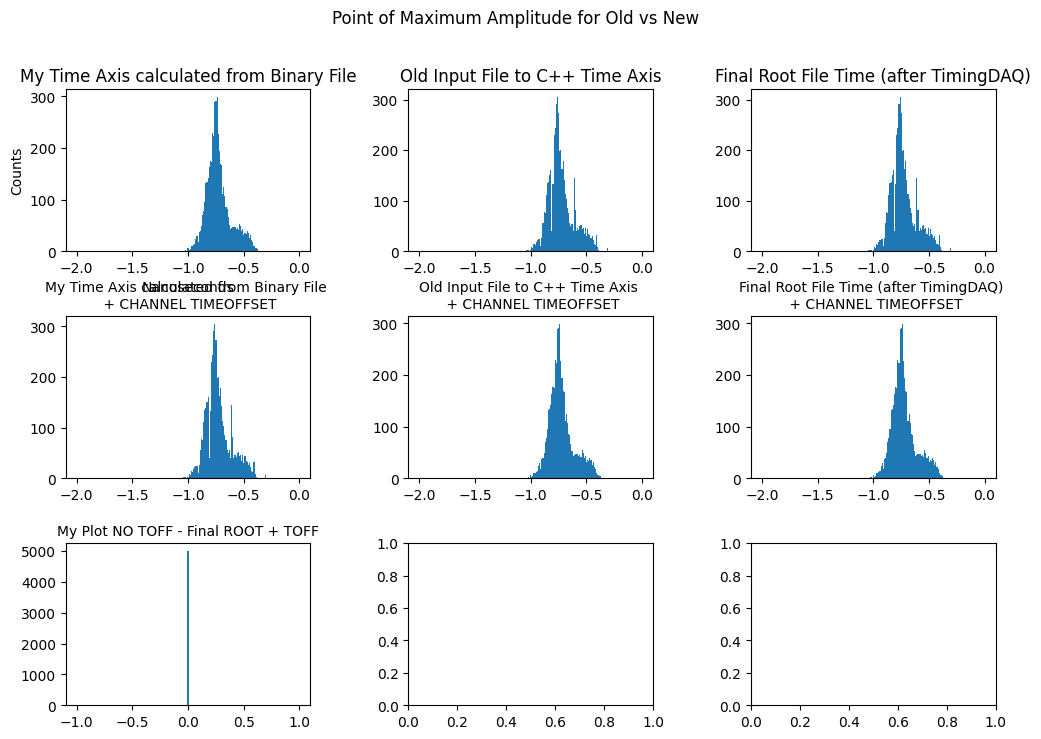

In [26]:
old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/run_5100.root")["pulse"].arrays()
old_lp2 = old.LP2_20[:,1]
old_lp2 = old.LP2_40[:,1]
old_volts= old.channel[:,1].to_numpy()
old_nano_times = old.time[:,0]*1e9
old_nano_times = old_nano_times.to_numpy()
old_timeoffset = old.timeoffsets[:,1]*1e9

conv_old = uproot.open(
"/home/users/hswanson13/ETL_TestingDAQ/unit_test/asserted_output/run_5100/converted_run5100.root")["pulse"].arrays()
conv_old_nano_times = conv_old.time[:,0]*1e9
conv_old_nano_times = conv_old_nano_times.to_numpy()
conv_old_volts = conv_old.channel[:,1].to_numpy()
conv_old_toffset = conv_old.timeoffsets[:,1]*1e9

ref_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C1--Trace5100.trc")
_, chorz = ref_data.segment_times

mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")
_, horz_off = mcp_data.segment_times

conv_max_amp_idxs = np.argmin(conv_old_volts, axis=-1)
event_idx = range(len(conv_max_amp_idxs))
conv_max_times = conv_old_nano_times[event_idx, conv_max_amp_idxs]

mine_nano_times = mcp_data.x*1e9
mine_max_amp_idxs = np.argmin(mcp_data.y, axis=-1)
event_idx = range(len(mine_max_amp_idxs))
mine_max_times = mine_nano_times[event_idx, mine_max_amp_idxs]


old_max_amp_idxs = np.argmin(old_volts, axis=-1)
event_idx = range(len(old_max_amp_idxs))
old_max_times = old_nano_times[event_idx, old_max_amp_idxs]

fig, axs = plt.subplots(3, 3, figsize=(12, 8), sharey=False)
fig.suptitle("Point of Maximum Amplitude for Old vs New")

bins = np.linspace(-2, 0, 200)
# Plot the first histogram on the first axis
axs[0,0].hist(np.clip(mine_max_times.flatten(), bins[0], bins[-1]), 
            bins=bins)
axs[0,0].set_title("My Time Axis calculated from Binary File")


toff = (chorz - horz_off)*1e9
mine_max_times_offseted = mine_max_times+toff
axs[1,0].hist(np.clip(mine_max_times_offseted.flatten(), bins[0], bins[-1]), 
            bins=bins)
axs[1,0].set_title("My Time Axis calculated from Binary File \n + CHANNEL TIMEOFFSET", fontsize=10)

# Plot the second histogram on the second axis
axs[0,1].hist(np.clip(conv_max_times.flatten(), bins[0], bins[-1]), 
            bins=bins)
axs[0,1].set_title("Old Input File to C++ Time Axis")

# Plot the second histogram on the second axis
conv_max_times_offseted = conv_max_times+conv_old_toffset.to_numpy()
axs[1,1].hist(np.clip(conv_max_times_offseted.flatten(), bins[0], bins[-1]), 
            bins=bins)
axs[1,1].set_title("Old Input File to C++ Time Axis \n + CHANNEL TIMEOFFSET", fontsize=10)

# Plot the second histogram on the second axis
axs[0,2].hist(np.clip(old_max_times.flatten(), bins[0], bins[-1]), 
            bins=bins)
axs[0,2].set_title("Final Root File Time (after TimingDAQ)")

# Plot the second histogram on the second axis
old_max_times_offseted = old_max_times + old_timeoffset.to_numpy()
axs[1,2].hist(np.clip(old_max_times_offseted.flatten(), bins[0], bins[-1]), 
            bins=bins,  
            )
axs[1,2].set_title("Final Root File Time (after TimingDAQ) \n + CHANNEL TIMEOFFSET", fontsize=10)

axs[0,0].set_xlabel("Nanoseconds")
axs[0,0].set_ylabel("Counts")


diff_bins = np.linspace(-1, 1, 200)
axs[2,0].hist(np.clip(mine_max_times.flatten() - old_max_times_offseted.flatten(), diff_bins[0], diff_bins[-1]), 
            bins=diff_bins,  
            )
axs[2,0].set_yticks(np.arange(0, 6000, 1000))
axs[2,0].set_title("My Plot NO TOFF - Final ROOT + TOFF", fontsize=10)

plt.subplots_adjust(wspace=0.4, hspace=0.4)